In [2]:
'''Concatenates both sessions and saves csvs of indivdual sessions and combined session (needs two sessions to run)
requires behavior files from subject and segmented eeg file (segment_edit) or scanned eeg file (scan_responses)'''
## Import necessary functions
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import csv
import ast
import os
from hdf5storage import loadmat
#from tkinter import filedialog #Only use if using file selecter

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn import svm
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

In [4]:
'''Produce csv files of subject for session and full
ONLY RUN if do not have Subject{sub}Full.csv and/or Session_#_Dataset.csv '''
for sub in ['105']:#,'3','4','5','6']: ##subject
    file_path = f'../data/Subject{sub}/{sub}_datashuffle.csv'
    ind_df =  pd.read_csv(file_path)
    # inds =  np.array(ind_df['Unnamed: 0'])
    inds =  np.array(ind_df['index'])
    # mlresponsearray = np.array(ind_df['income-pred'])
    mlresponsearray = np.array(ind_df['ML Pred'])
    cleanlst = []
    for ses in [1,2]:
    # for ses in [1]:
        # path = f'segmented/{sub}SS{ses}_segmented.hdf.mat'
        path = f'./scanned/{sub}SS{ses}_scanned.hdf.mat'
        cleanlst.append(path)
    ipad = 0
    for ses,f in enumerate(cleanlst):
        subinf = loadmat(f)
        ses = str(ses+1)
        if ses == '2':
            ipad = answerarray.shape[0]
        responsearray = subinf['choice']
        # print(responsearray)
        answerarray = subinf['answer']
        #response = outdict['cedrus_response']
        featsarray = subinf['ordered_features']
        mlresponsearray = subinf['model_response']
        #mlresponsearray = np.array(subinf['model_response'].shape)
        rows = []
        for i in range(answerarray.shape[0]):
            if responsearray[i] == -1:
                print(f'Invalid Trial {i+ipad}')
                continue
            row = {}
            feats = featsarray[i*10:i*10+9]
            feord = []
            for fe in feats:
                key,val = fe.split(': ')
                row[key] = val
                feord.append(key)
            row['Response'] = responsearray[i]
            row['Real Answer'] = answerarray[i]
            row['Model'] = mlresponsearray[i] ## first pass error in collection of model response run last block in script to fix
            row['Original Ind'] = inds[i+ipad]
            row['Feat Order'] = np.array(feord)
            #print(i + ipad)
            rows.append(row)


        new = pd.DataFrame.from_dict(rows, orient='columns')
        fl = f'../data/Subject{sub}/{sub}_Session_{ses}_Dataset.csv'
        new.to_csv(fl,index = False)

#     ### combine both sessions
    csv1 = f'../data/Subject{sub}/{sub}_Session_1_Dataset.csv'
    csv2 = f'../data/Subject{sub}/{sub}_Session_2_Dataset.csv'
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)
    dffull = pd.concat([df1,df2],axis = 0)
    fn = f'../data/Subject{sub}/Subject{sub}Full.csv'
    dffull.to_csv(fn,index = False) ### 

Invalid Trial 130


Number of samples: 434
Number of features: 9
Number of categorical features: 7
Number of numerical features: 2
Accuracy: 0.725 (0.088)
Accuracy: 0.669 (0.053)


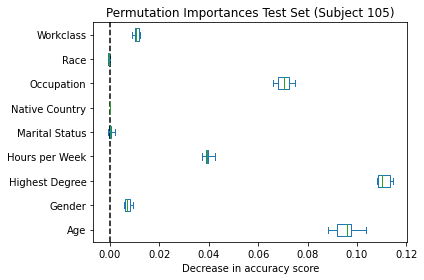

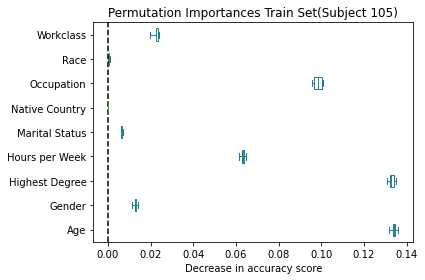

Computing partial dependence plots...
Computing partial dependence corrs...


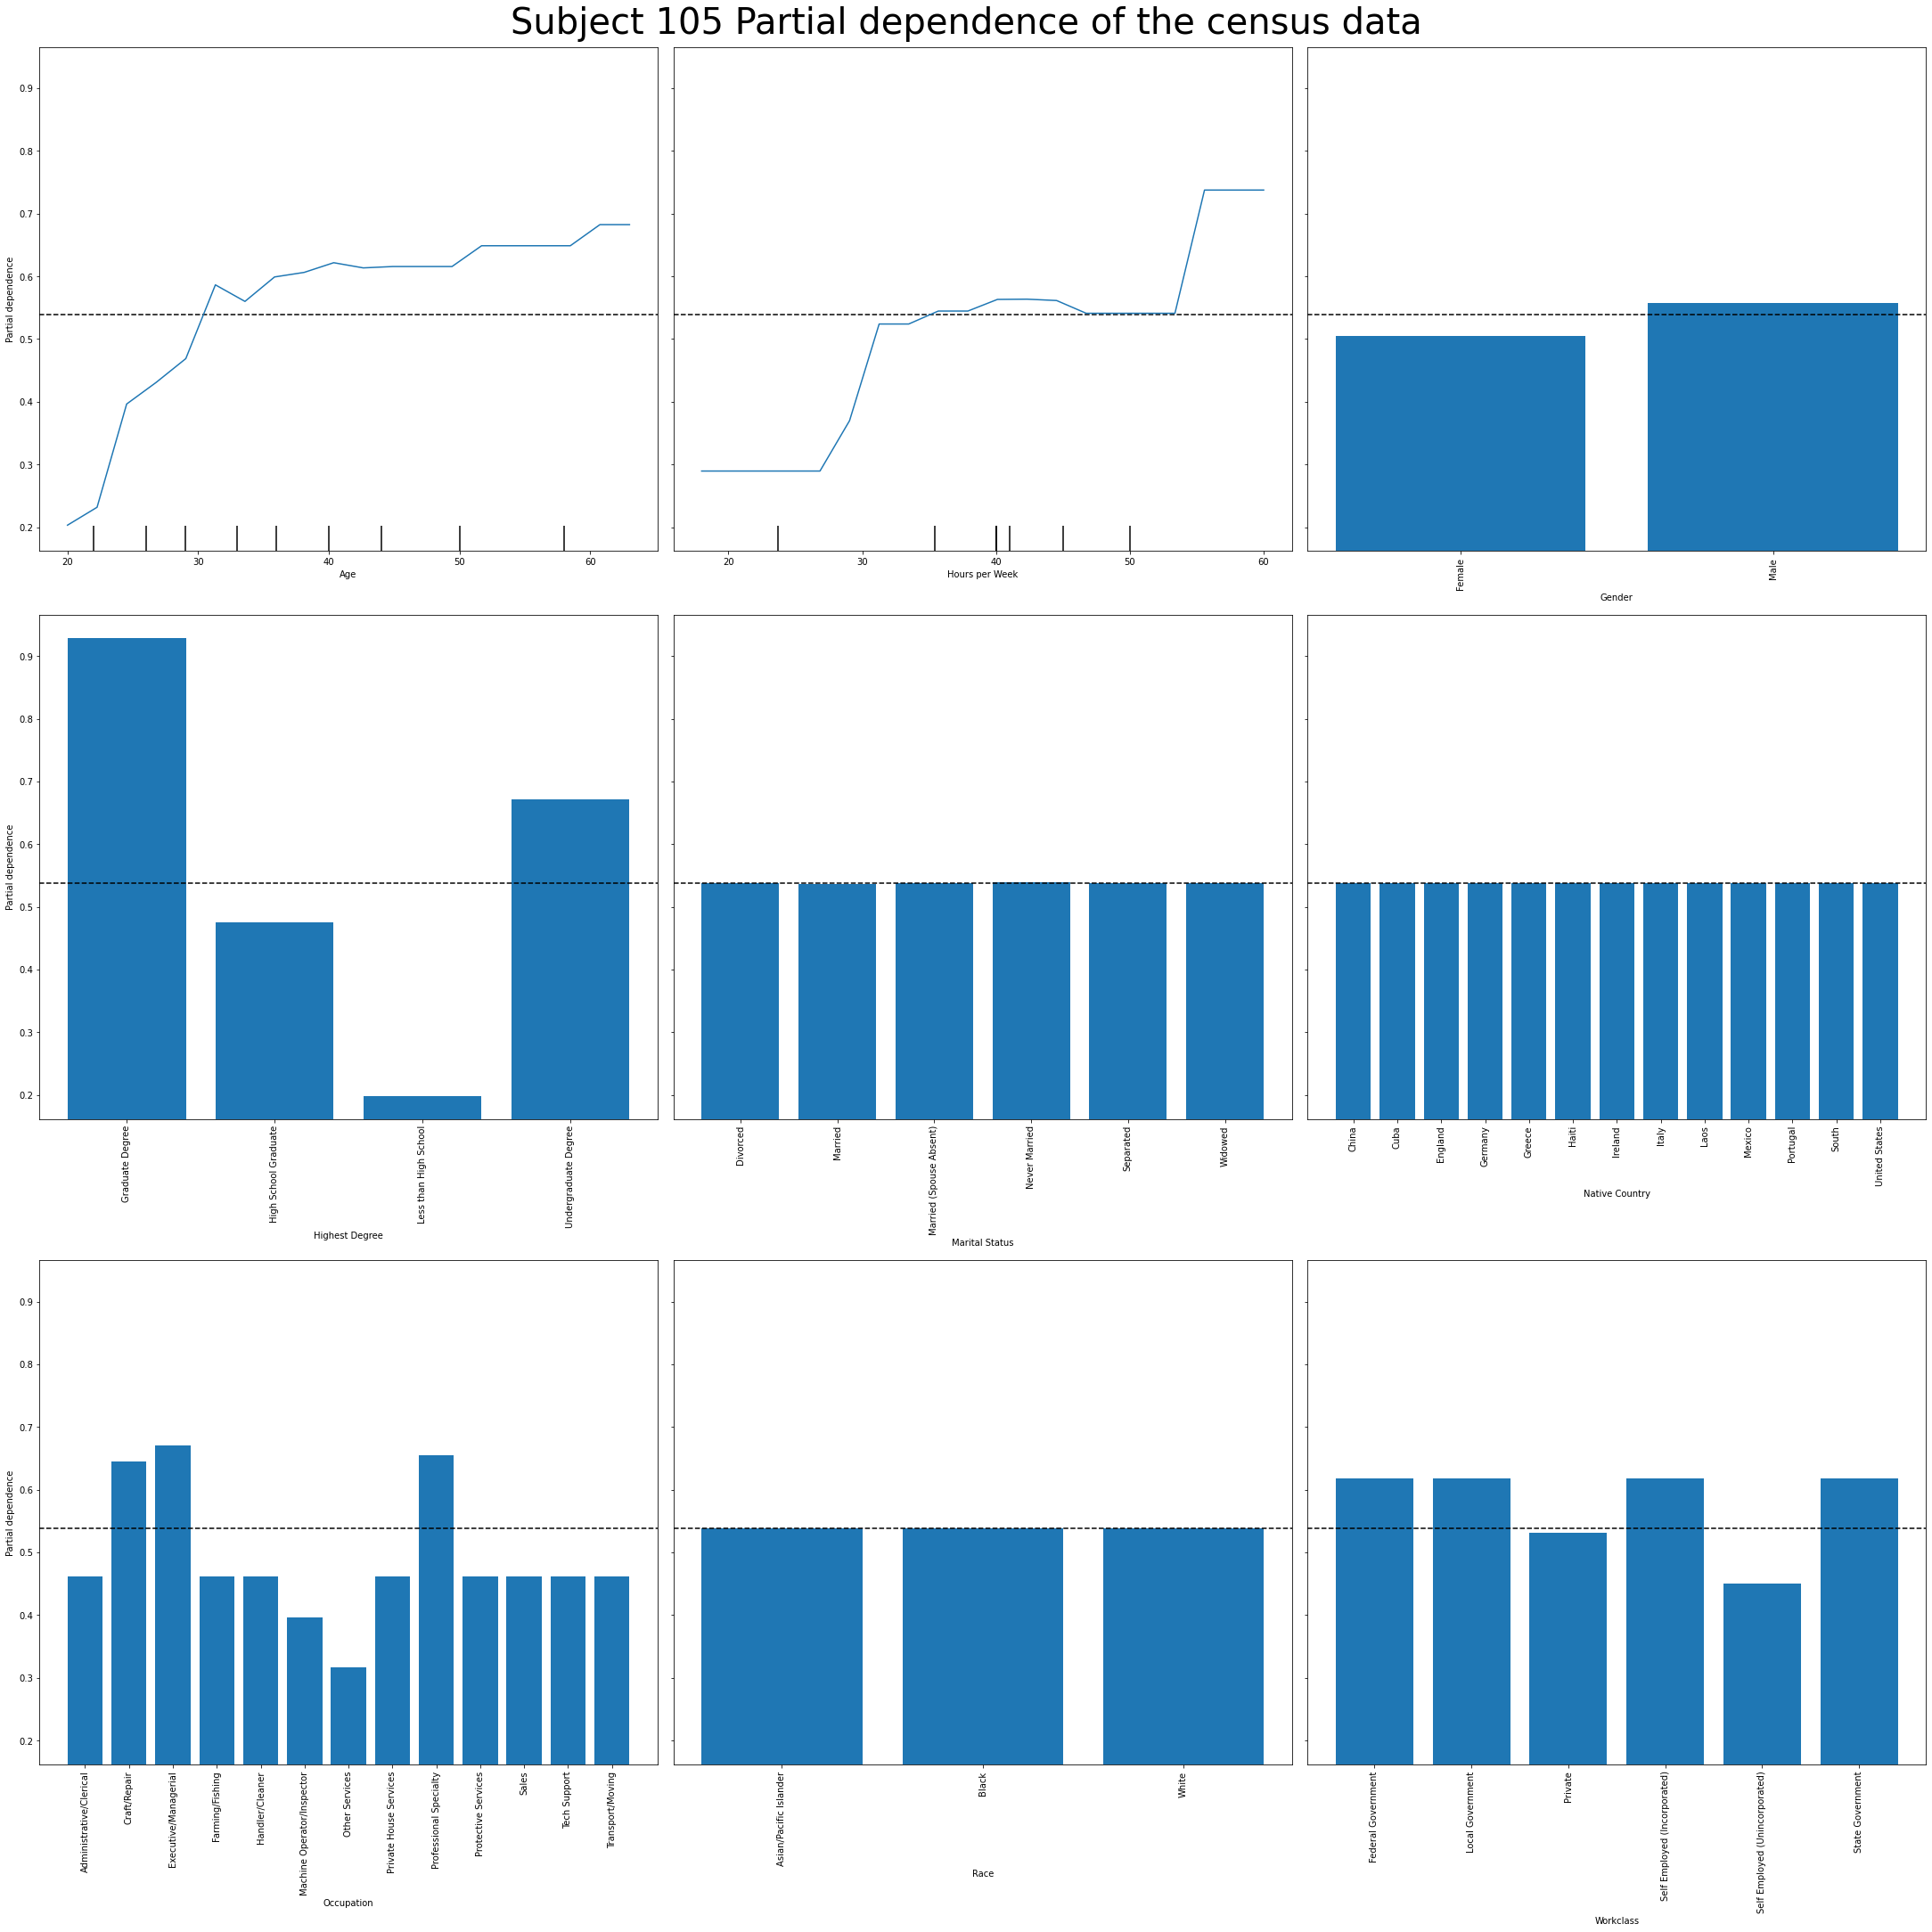

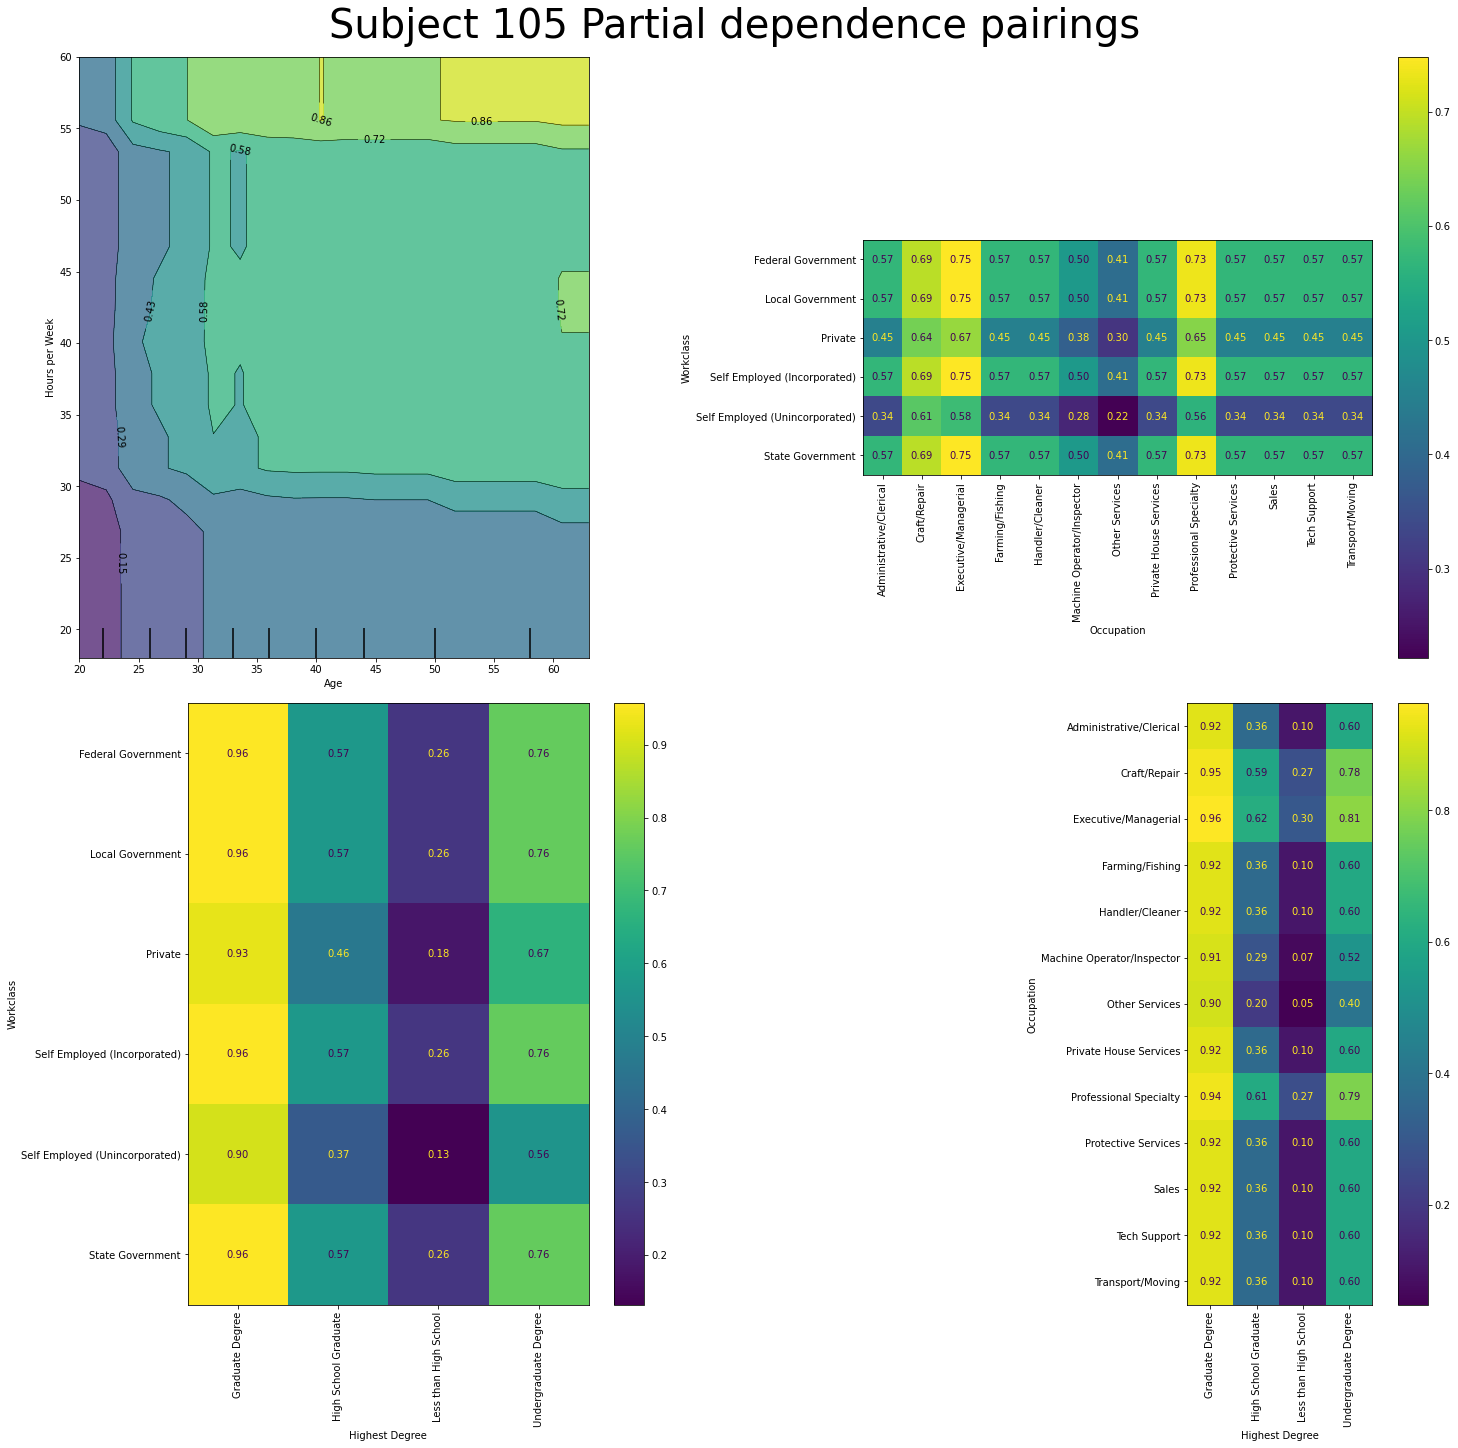

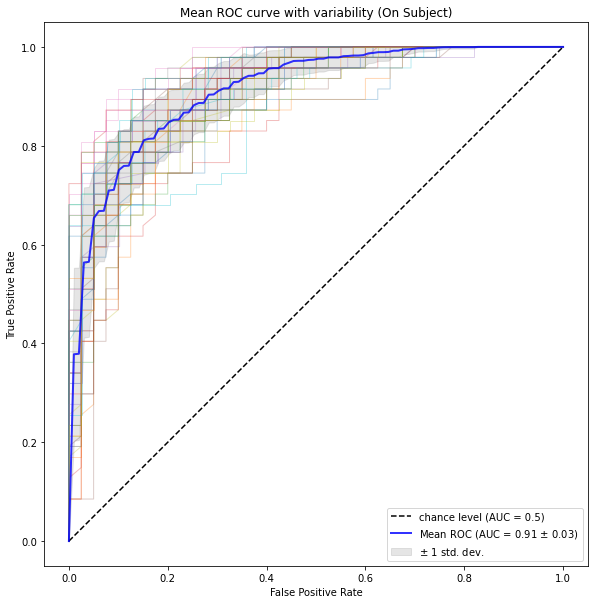

Accuracy: 0.713 (0.089)
Accuracy: 0.669 (0.053)
Computing partial dependence plots...
Computing partial dependence corrs...


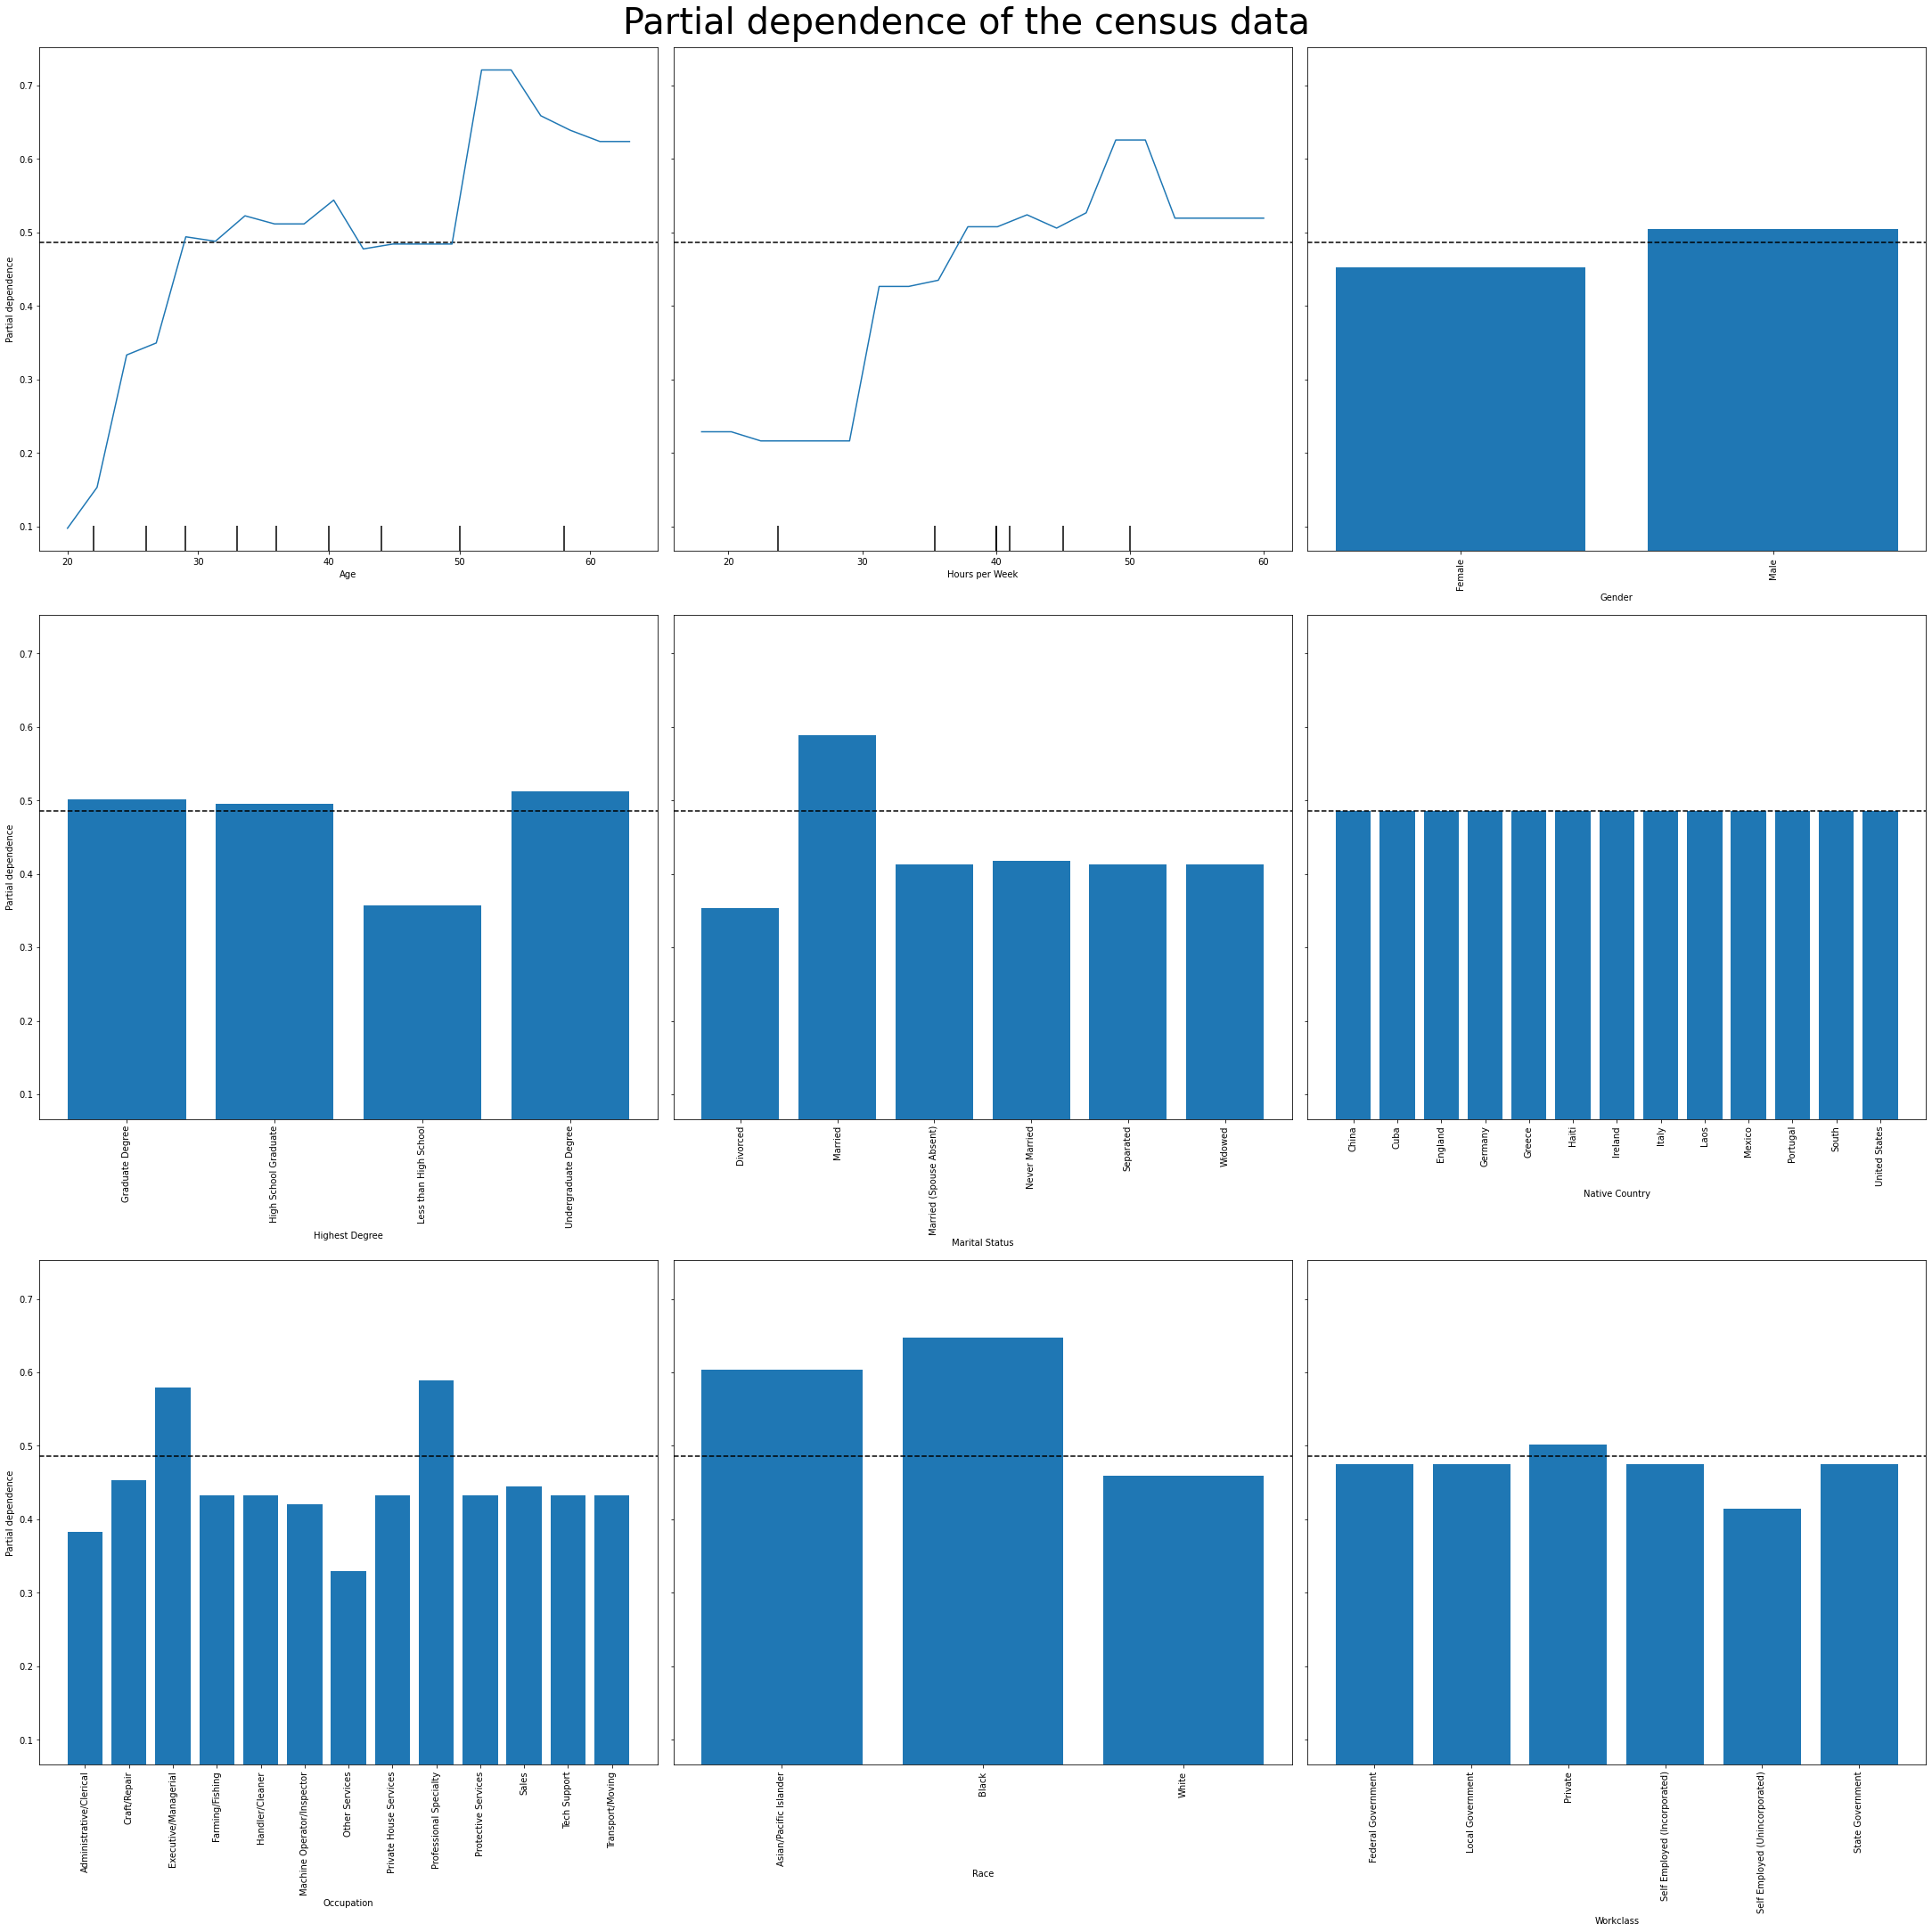

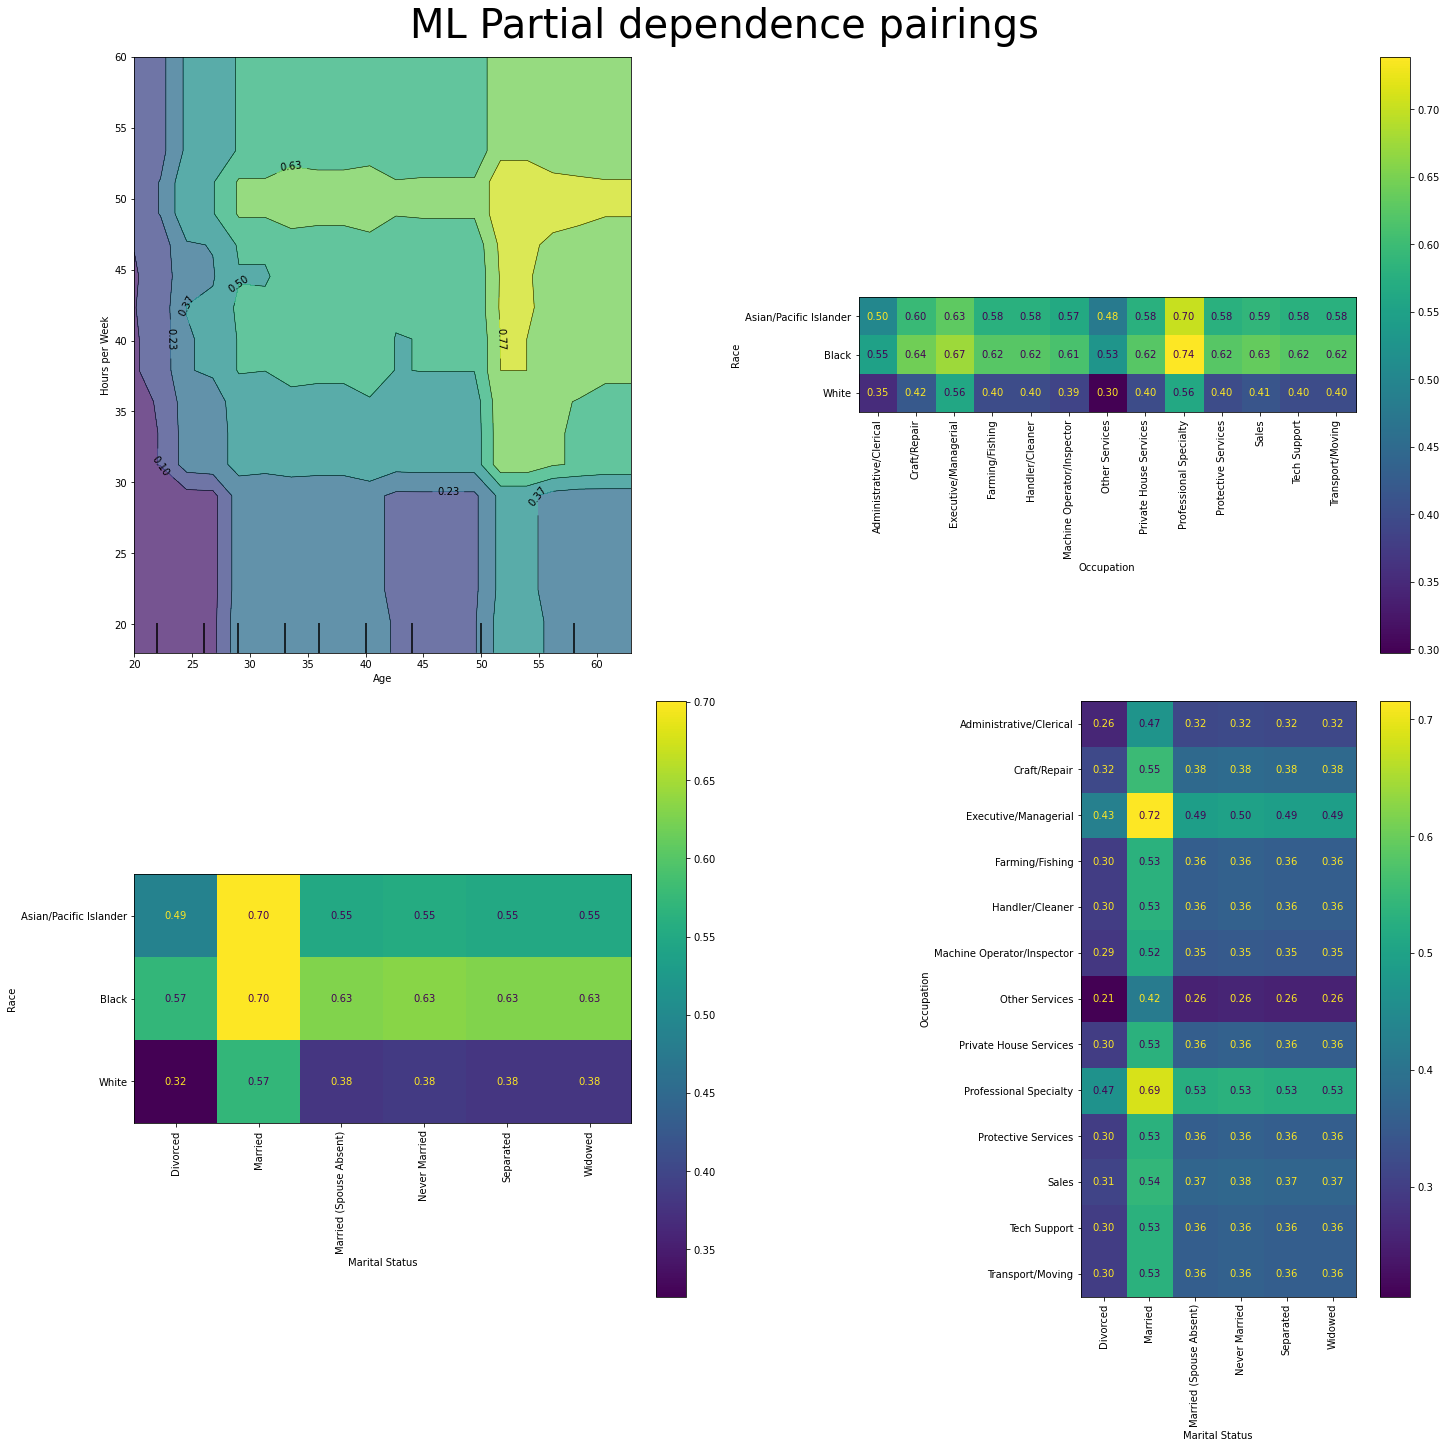

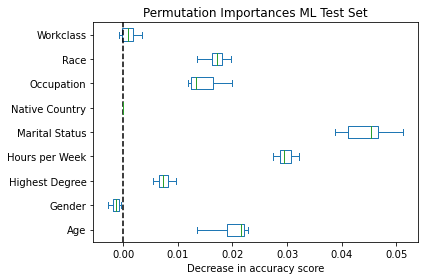

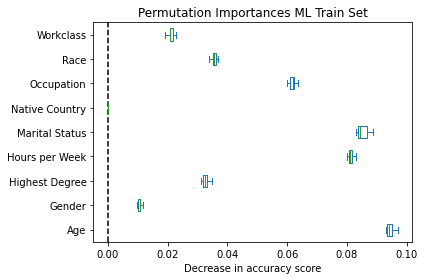

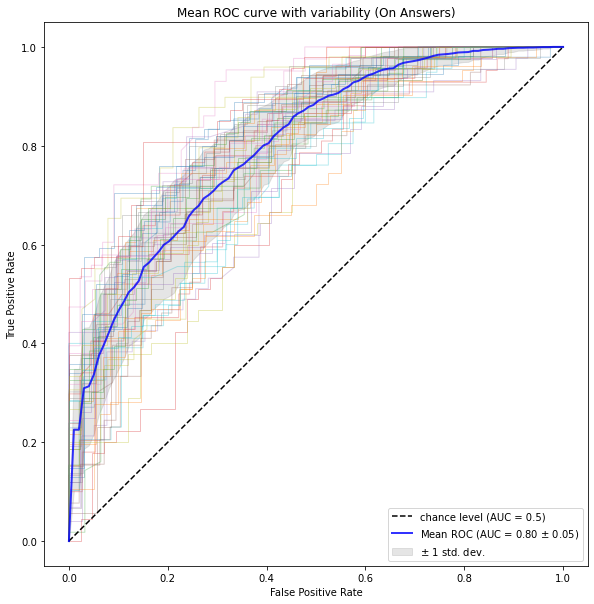

In [6]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
min_samples_leaf = 20 #default = 1
max_depth = 3 #optimizes for experiment dataset; default = None
max_leaf_nodes = 31 #default = 31
test_size = 0.25
sub = '105'

## Import Data
#### run full dataset, will not work well with one session
file_path = f'../data/Subject{sub}/Subject{sub}Full.csv'
title = file_path.split('/')[2]
sub_df =  pd.read_csv(file_path)


y = sub_df[['Response']].copy().values.squeeze()
y_real = sub_df[['Real Answer']].copy().values.squeeze()
try:
    numFeatures = list(sub_df.select_dtypes(include = 'number').drop(labels=['Response', 'Real Answer','Model','Original Ind'], axis=1))
except:
    print('Model not in df')
    numFeatures = list(sub_df.select_dtypes(include = 'number').drop(labels=['Response', 'Real Answer','Original Ind'], axis=1))
catFeatures = list(sub_df.select_dtypes(include = object).drop(labels=['Feat Order'], axis=1))
x = sub_df[catFeatures + numFeatures].copy()
### Mark categorical features
x[catFeatures] = x[catFeatures].astype("category")

numFeatures.sort()
catFeatures.sort()
### Check shape of feature data set
n_categorical_features = x.select_dtypes(include="category").shape[1]
n_numerical_features = x.select_dtypes(include="number").shape[1]
print(f"Number of samples: {x.shape[0]}")
print(f"Number of features: {x.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")
strainlst = []
stestlst = []
mtrainlst = []
mtestlst = []
#yproblst = []


    
for it in range(100):
    rand_state = it
    ### Create test and train set from existing dataframe
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=rand_state)
    X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(x, y_real, test_size=test_size, random_state=rand_state)
    ## Process categorical features for OneHotEncoder
    one_hot_encoder = make_column_transformer(
        (
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
            make_column_selector(dtype_include="category"),
        ),
        verbose_feature_names_out = False,
        remainder="passthrough",
    )
    hist_one_hot = make_pipeline(
         one_hot_encoder, HistGradientBoostingClassifier(random_state=42)
    )
    hist_one_hot = Pipeline([
        ("preprocess",one_hot_encoder), ("classifier", HistGradientBoostingClassifier(random_state=rand_state)),
    ]
    )

    '''Model that predicts subject's responses'''
    ## Fit training set to model
    model = hist_one_hot.set_params(classifier__min_samples_leaf=min_samples_leaf,classifier__max_depth = max_depth, classifier__max_leaf_nodes = max_leaf_nodes).fit(X_train, y_train)

    train_result = permutation_importance(
            model, X_train, y_train, n_repeats=10, random_state=rand_state, n_jobs=2
            )
    test_results = permutation_importance(
            model, X_test, y_test, n_repeats=10, random_state=rand_state, n_jobs=2
            )

    sorted_importances_idx = train_result.importances_mean.argsort()

    train_importances = pd.DataFrame(
            train_result.importances[sorted_importances_idx].T,
            columns=x.columns[sorted_importances_idx],
            )
    test_importances = pd.DataFrame(
            test_results.importances[sorted_importances_idx].T,
            columns=x.columns[sorted_importances_idx],
            )
    strainlst.append(train_importances)
    stestlst.append(test_importances)

    '''Model using real answers same order and valid trials as model predicting responses'''

    model = hist_one_hot.set_params(classifier__min_samples_leaf=min_samples_leaf,classifier__max_depth = max_depth, classifier__max_leaf_nodes = max_leaf_nodes).fit(X_train_real, y_train_real)


    train_result = permutation_importance(
            model, X_train_real, y_train_real, n_repeats=10, random_state=rand_state, n_jobs=2
            )
    test_results = permutation_importance(
            model, X_test_real, y_test_real, n_repeats=10, random_state=rand_state, n_jobs=2
            )

    sorted_importances_idx = train_result.importances_mean.argsort()

    train_importances = pd.DataFrame(
            train_result.importances[sorted_importances_idx].T,
            columns=x.columns[sorted_importances_idx],
            )
    test_importances = pd.DataFrame(
            test_results.importances[sorted_importances_idx].T,
            columns=x.columns[sorted_importances_idx],
            )
    mtrainlst.append(train_importances)
    mtestlst.append(test_importances)
    #yproblst.append(y_prob)


'''Model that predicts subject's responses'''
subdata = {}
rand_state = 42
## Fit training set to model
model = hist_one_hot.set_params(classifier__min_samples_leaf=min_samples_leaf,classifier__max_depth = max_depth, classifier__max_leaf_nodes = max_leaf_nodes).fit(X_train, y_train)

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_repeats=10, random_state=rand_state)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
subdata['Sub Test Acc Mean'] = np.mean(n_scores)
subdata['Sub Test Acc STD'] = np.std(n_scores)
n_scores = cross_val_score(model, X_train_real, y_train_real, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
subdata['Sub Train Acc Mean'] = np.mean(n_scores)
subdata['Sub Train Acc STD'] = np.std(n_scores)

## empty data frame to use for appending
df=pd.DataFrame()
#looping through each item in list and appending to empty data frame
for i in strainlst:
    df = df.append(i)
# group by and calculating mean on index
train_importances = df.groupby(level=0).mean()
train_importances = train_importances.sort_index(axis = 1)

## empty data frame to use for appending
df=pd.DataFrame()
#looping through each item in list and appending to empty data frame
for i in stestlst:
    df = df.append(i)
# group by and calculating mean on index
test_importances = df.groupby(level=0).mean()
test_importances = test_importances.sort_index(axis = 1)
    
    
# fig, ax = plt.subplots(figsize=(10, 10))
ax = test_importances.plot.box(vert=False, whis=10)
ax.set_title(f"Permutation Importances Test Set (Subject {sub})")
ax.set_xlabel("Decrease in accuracy score")
ax.axvline(x=0, color="k", linestyle="--")
ax.figure.tight_layout()
fn = f'../data/Subject{sub}/{sub}Subject_Test_Perm_Imp.png'
# plt.savefig(fn,format = 'png')
plt.show()

# fig, ax = plt.subplots(figsize=(10, 10))
ax = train_importances.plot.box(vert=False, whis=10)
ax.set_title(f"Permutation Importances Train Set(Subject {sub})")
ax.set_xlabel("Decrease in accuracy score")
ax.axvline(x=0, color="k", linestyle="--")
ax.figure.tight_layout()
fn = f'../data/Subject{sub}/{sub}Subject_Train_Perm_Imp2.png'
# plt.savefig(fn,format = 'png')
plt.show()
test_importances.to_csv('../data/Subject'+sub+'/test_imp_'+sub+'.csv')
train_importances.to_csv('../data/Subject'+sub+'/train_imp_'+sub+'.csv')

### partial dependence plots
train_med = train_importances.drop(['Hours per Week','Age'],axis = 1).max(axis=0).to_dict()
train_per = list(train_med.values())
train_per.sort()
train_per = train_per[-3:]
topfeat = []

for per in train_per:
    per = list(train_med.keys())[list(train_med.values()).index(per)]
    topfeat.append(per)
    
from itertools import combinations
combos = combinations(topfeat, 2)
combos = [i for i in combos]

common_params = {
    "subsample": 100,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": rand_state,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": numFeatures+catFeatures,#topfeat,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": catFeatures,
}

sub_pd = {}
for i in X_train.columns:
    sub_pardep = partial_dependence(
        model, X = X_train, features = i,categorical_features = catFeatures, grid_resolution = 20)
    sub_pd[i] = dict(sub_pardep)
for depcat in ['Age','Hours per Week']:
    newdict = {}
    avlist = []
    vallist = []
    # print(sub_pd[depcat]['average'])
    for bavg,bval in zip(sub_pd[depcat]['average'],sub_pd[depcat]['values']):
        for bavg,bval in zip(bavg,bval):
            avlist.append(bavg)
            vallist.append(round(bval,0))
    newdict['average'] = np.array([avlist])
    newdict['values'] = np.array([vallist])
    sub_pd[depcat] = newdict
        
bias = sum(y_train)/len(y_train)    

_, ax = plt.subplots(ncols=3, nrows=3, figsize=(30, 30), constrained_layout=True)
for i in range(3):
    for j in range(3):
        ax[i,j].axhline(y = bias, color = 'k', linestyle = '--')
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)


_ = display.figure_.suptitle(
    f"Subject {sub} Partial dependence of the census data",
    fontsize=40,
)
fn = f'../data/Subject{sub}/{sub}ValueDependence.png'
# plt.savefig(fn,format ='png', bbox_inches="tight")

print("Computing partial dependence corrs...")
features_info = {
    # features of interest
    "features": [('Age','Hours per Week')] + combos,#topfeat,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": catFeatures,
}

_, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 20), constrained_layout=True)
#for i in range(2):
#    for j in range(2):
#        ax[i,j].axhline(y = 0.5, color = 'k', linestyle = '--')
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle(
    f"Subject {sub} Partial dependence pairings",
    fontsize=40,
)
fn = f'../data/Subject{sub}/{sub}PairDependence.png'
#plt.savefig(fn,format ='png', bbox_inches="tight")


tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10, 10))
for fold, (train, test) in enumerate(cv.split(x, y)):  ##############################################################################
    model.fit(x.iloc[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        model,
        x.iloc[test],
        y[test],
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability (On Subject)",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[-3:]
labels = labels[-3:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
fn =f'../data/Subject{sub}/{sub}_ROC_Curve.png'
# plt.savefig(fn,format = 'png',dpi = 300)
plt.show()


subdata['Sub Mean TPR'] = mean_tpr
subdata['Sub Mean AUC'] = mean_auc
subdata['Sub STD AUC'] = std_auc
subdata['Sub STD TPR'] = std_tpr
subdata['Sub Upper TPR'] = tprs_upper
subdata['Sub Lower TPR'] = tprs_lower
subdata['Sub PD'] = sub_pd
subdata['Sub bias'] = bias



'''Model using real answers same order and valid trials as model predicting responses'''
model = hist_one_hot.set_params(classifier__min_samples_leaf=min_samples_leaf,classifier__max_depth = max_depth, classifier__max_leaf_nodes = max_leaf_nodes).fit(X_train_real, y_train_real)


# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_repeats=10, random_state=rand_state)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_test_real, y_test_real, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
subdata['ML Test Acc Mean'] = np.mean(n_scores)
subdata['ML Test Acc STD'] = np.std(n_scores)
n_scores = cross_val_score(model, X_train_real, y_train_real, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
subdata['ML Train Acc Mean'] = np.mean(n_scores)
subdata['ML Train Acc STD'] = np.std(n_scores)





## empty data frame to use for appending
df=pd.DataFrame()
#looping through each item in list and appending to empty data frame
for i in mtrainlst:
    df = df.append(i)
# group by and calculating mean on index
train_importances = df.groupby(level=0).mean()
train_importances = train_importances.sort_index(axis = 1)

## empty data frame to use for appending
df=pd.DataFrame()
#looping through each item in list and appending to empty data frame
for i in mtestlst:
    df = df.append(i)

# group by and calculating mean on index
test_importances = df.groupby(level=0).mean()
test_importances = test_importances.sort_index(axis = 1)

### partial dependence plots


train_med = train_importances.drop(['Hours per Week','Age'],axis = 1).max(axis=0).to_dict()
train_per = list(train_med.values())
train_per.sort()
train_per = train_per[-3:]
topfeat = []

for per in train_per:
    per = list(train_med.keys())[list(train_med.values()).index(per)]
    topfeat.append(per)

combos = combinations(topfeat, 2)
combos = [i for i in combos]

common_params = {
    "subsample": 100,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": rand_state,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": numFeatures+catFeatures,#topfeat,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": catFeatures,
}

ml_pd = {}
for i in X_train_real.columns:
    ml_pardep = partial_dependence(
        model, X = X_train_real, features = i,categorical_features = catFeatures, grid_resolution = 20)
    ml_pd[i] = dict(ml_pardep)
for depcat in ['Age','Hours per Week']:
    newdict = {}
    avlist = []
    vallist = []
    # print(ml_pd[depcat]['average'])
    for bavg,bval in zip(ml_pd[depcat]['average'],ml_pd[depcat]['values']):
        for bavg,bval in zip(bavg,bval):
            avlist.append(bavg)
            vallist.append(round(bval,0))
    newdict['average'] = np.array([avlist])
    newdict['values'] = np.array([vallist])
    ml_pd[depcat] = newdict
bias = sum(y_train_real)/len(y_train_real)



_, ax = plt.subplots(ncols=3, nrows=3, figsize=(30, 30), constrained_layout=True)
for i in range(3):
    for j in range(3):
        ax[i,j].axhline(y = bias, color = 'k', linestyle = '--')
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train_real,
    **features_info,
    ax=ax,
    **common_params,
)
#plt.axhline(y = 0.5, color = 'b', linestyle = '-')

_ = display.figure_.suptitle(
    "Partial dependence of the census data",
    fontsize=40,
)
fn = f'../data/Subject{sub}/ML{sub}ValueDependence.png'
# plt.savefig(fn,format ='png', bbox_inches="tight",dpi = 300)

print("Computing partial dependence corrs...")
features_info = {
    # features of interest
    "features": [('Age','Hours per Week')] + combos,#topfeat,
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": catFeatures,
}
_, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 20), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    model,
    X_train_real,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle(
    f"ML Partial dependence pairings",
    fontsize=40,
)
fn = f'../data/Subject{sub}/ML{sub}PairDependence.png'
# plt.savefig(fn,format ='png', bbox_inches="tight",dpi = 300)

# fig, ax = plt.subplots(figsize=(10, 10))
ax = test_importances.plot.box(vert=False, whis=10)
ax.set_title(f"Permutation Importances ML Test Set")
ax.set_xlabel("Decrease in accuracy score")
ax.axvline(x=0, color="k", linestyle="--")
ax.figure.tight_layout()
fn =f'../data/Subject{sub}/ML{sub}_Test_Perm_Imp.png'
# plt.savefig(fn,format = 'png',dpi = 300)
plt.show()

test_importances.to_csv('../data/Subject'+sub+'/test_imp_ml'+sub+'.csv')
train_importances.to_csv('../data/Subject'+sub+'/train_imp_ml'+sub+'.csv')

# fig, ax = plt.subplots(figsize=(10, 10))
ax = train_importances.plot.box(vert=False, whis=10)
ax.set_title(f"Permutation Importances ML Train Set")
ax.set_xlabel("Decrease in accuracy score")
ax.axvline(x=0, color="k", linestyle="--")
ax.figure.tight_layout()
fn =f'../data/Subject{sub}/ML{sub}_Train_Perm_Imp.png'
# plt.savefig(fn,format = 'png',dpi = 300)
plt.show()
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10, 10))
for fold, (train, test) in enumerate(cv.split(x, y_real)):
    model.fit(x.iloc[train], y_real[train])
    viz = RocCurveDisplay.from_estimator(
        model,
        x.iloc[test],
        y[test],
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability (On Answers)",
)
ax.axis("square")
ax.legend(loc="lower right")
plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[-3:]
labels = labels[-3:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
fn =f'../data/Subject{sub}/{sub}_MLROC_Curve.png'
# plt.savefig(fn,format = 'png',dpi = 300)
plt.show()

subdata['ML Mean TPR'] = mean_tpr
subdata['ML Mean AUC'] = mean_auc
subdata['ML STD AUC'] = std_auc
subdata['ML STD TPR'] = std_tpr
subdata['ML Upper TPR'] = tprs_upper
subdata['ML Lower TPR'] = tprs_lower
subdata['ML PD'] = ml_pd
subdata['ML bias'] = bias
from hdf5storage import loadmat, savemat
outpath = f'../data/Subject{sub}/'
outname = f'Sub{sub}MLPredictions.hdf'
savemat(outpath+outname,subdata,store_python_metadata=True)

#### Extra snippets for fixing error in old dataset, delete later

In [22]:
'''Adds model cross validated predictions'''
model_ind = pd.DataFrame()
y_trpred = cross_val_predict(model, X_train_real, y_train_real, cv=3)
y_tepred = cross_val_predict(model, X_test_real, y_test_real, cv=3)
tr_ind = np.array(X_train.index)
te_ind = np.array(X_test.index)
y_pred = np.concatenate((y_trpred,y_tepred))
indss = np.concatenate((tr_ind,te_ind))
model_ind['Index'] = indss
model_ind['Model'] = y_pred
model_ind = model_ind.sort_values(by=['Index'])
sub_df['Model'] = np.array(model_ind['Model'])
fn = f'data/Subject{sub}/Subject{sub}Full.csv'
# sub_df.to_csv(fn,index = False) ### 
model_ind = model_ind.reset_index(drop = True)
ipad = 0
for ses in ['1','2']:
    if ses == '2':
        ipad = trrange
    fl = f'data/Subject{sub}/{sub}_Session_{ses}_Dataset.csv'
    subses = pd.read_csv(fl)
    trrange = len(subses)
    subses['Model'] = np.array(model_ind['Model'][ipad:trrange+ipad])
    #subses.to_csv(fl,index = False)
    #print(ipad,trrange)
sub_df['Model']
model_accuracy  = (np.array(model_ind['Model']) == np.array(sub_df['Real Answer'])).sum()/len(np.array(model_ind['Model']) == np.array(sub_df['Real Answer']))
print(f'The model\'s accuracy when trained and tested on smaller dataset: {model_accuracy}')

The model's accuracy when trained and tested on smaller dataset: 0.6612903225806451
